In [1]:
import pyEDITH as pE
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# # set your environment variables:
# os.environ["YIP_CORO_DIR"] = "/Users/mhcurrie/science/packages/yippy/yips/"
# os.environ["SCI_ENG_DIR"] = "/Users/mhcurrie/science/packages/Sci-Eng-Interface/hwo_sci_eng/"

# or you can put these in your .zshrc as 
#export SCI_ENG_DIR=/Users/mhcurrie/science/packages/Sci-Eng-Interface/hwo_sci_eng
#export YIP_CORO_DIR=/Users/mhcurrie/science/packages/yippy/yips/



# Testing pyEDITH spectroscopy mode

## Set up a parameters dictionary

In [2]:
# this is where all the input parameters are stored for EDITH
parameters = {}
parameters["observing_mode"] = "IFS" # tells ETC to use spectroscopy (IFS) mode


## Set up the observation object. Eventually, this is where the exposure time or SNR will be placed after calculation. 

In [3]:
# to set up the observation object, we need to specify a few overarching parameters:
parameters["wavelength"] = np.linspace(0.45, 1.5, 100) # define a wavelength grid in microns
parameters["nlambd"] = len(parameters["wavelength"]) # number of wavelengths
parameters["snr"] = 5*np.ones_like(parameters["wavelength"]) # the SNR you want for each spectral bin 
parameters["CRb_multiplier"] = 2. # factor to multiply the background by (used for differential imaging)
parameters["photometric_aperture_radius"] = None#0.85 # radius of the photometric aperture in units of lambda/D
parameters["psf_trunc_ratio"] = 0.3 # truncate the off-axis PSFs at this level 

#NOTE: there are more parameters we can define (see below), but these are the basics for now.


observation = pE.Observation() # define the observation object
observation.load_configuration(parameters) # load the specified configuration in the parameters dict 
observation.set_output_arrays()
observation.validate_configuration()

print(f"All params in Observation():")
for key in observation.__dict__.keys():
    print("-->", key)


All params in Observation():
--> td_limit
--> wavelength
--> SNR
--> photometric_aperture_radius
--> psf_trunc_ratio
--> CRb_multiplier
--> nlambd
--> tp
--> exptime
--> fullsnr
--> snr_ez


## Set up the astrophysical scene

### First let's do something dumb and model the star/planet as blackbodies for testing

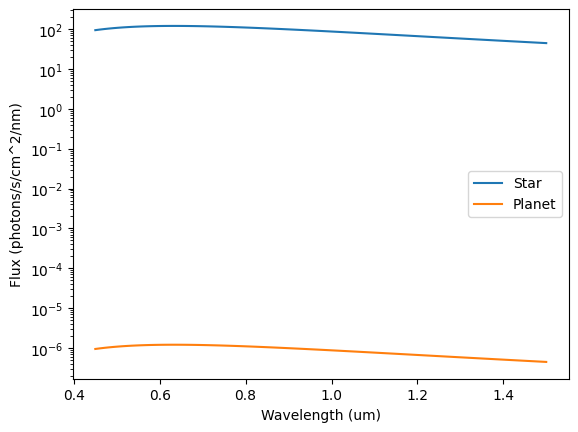

In [4]:
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot import units as synphot_u
import astropy.units as u 
import astropy.constants as c 

def compute_blackbody_photon_flux(temp, wavelengths):
    """Generate photon flux density (photon/s/cm^2/um) for a blackbody at 1 cm^2."""
    bb = SourceSpectrum(BlackBodyNorm1D, temperature=temp)
    

    flux_photlam = bb(wavelengths)#.value * 1/(u.s * u.cm**2 * u.AA) # photons/s/cm2/A
    #flux_photlam = flux_photlam.to(1 / (u.s * u.cm**2 * u.nm)) # convert to 1/nm
    return flux_photlam

def compute_star_flux_observed(stellar_flux_surface, R_star, dist):
    """Scale stellar surface flux to observer distance."""
    scale = (R_star / d_obs)**2
    return stellar_flux_surface * scale.decompose()


# temp and distance to star
Tstar = 5800 * u.K
dist = 10 * u.pc

# calculate the observed Fs_over_F0 
Fs_over_F0 = compute_blackbody_photon_flux(Tstar, parameters["wavelength"]*u.um)
Fs_over_F0 = Fs_over_F0.to(u.photon / (u.s * u.cm**2 * u.nm)) # convert to pyEdith units
Fstar_obs_10pc = Fs_over_F0 * (1000*u.pc/dist)**2 # this gives the flux at 1 kpc. Scale to the distance of the star
contrast = 1e-8 # !!!!! let's look at a very bright planet !!!!! 
Fplan_obs = Fstar_obs_10pc*contrast
FpFs = Fplan_obs / Fstar_obs_10pc
plt.figure()
plt.plot(parameters["wavelength"]*u.um, Fstar_obs_10pc, label="Star")
plt.plot(parameters["wavelength"]*u.um, Fplan_obs, label="Planet")
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (photons/s/cm^2/nm)")
plt.yscale("log")
plt.legend()

In [5]:
# we need several more parameters to define the astrophysical scene. These include parameters related to the star, planet, zodi/exozodi

# As an example, lets take the star HD 102365. It is a sun-like star (spectral type G2V) ~10 pc away. 
# It is also a Tier A target star from the NASA ExEP HWO target star list. 

# STAR
parameters["Lstar"] = 1. # luminosity of the star in solar luminosities
parameters["distance"] = 10. # distance to the system in pc
# Note: we can work in either mag or flux units. Let's choose to work in flux units. 

parameters["stellar_angular_diameter"] = 0.01 # angular diameter of the star in arcsec
parameters["Fstar_10pc"] = Fstar_obs_10pc.value # Fs_over_F0 modeled as a blackbody (see above)
#parameters["FstarV_10pc"] = v_band_flux.value # V-band flux of the star; you don't have to pre-calculate this, ETC will do it for you

# PLANET
parameters["separation"] = 0.1 # planetary separation in arcsec
parameters["Fp/Fs"] = FpFs.value
parameters["Fp_min/Fs"] = 1e-11 # minimum detectable planet 


# SCENE
parameters["nzodis"] = 3. # number of zodis for exozodi estimate
parameters["ra"] = 176.6292 # approximate ra of HD 102365. WARNING: do not use this number for science. 
parameters["dec"] = -40.5003 # approximate dec of HD 102365. WARNING: do not use this number for science. 

# ALTERNATIVE WAY OF SETTING PARAMS (in mags)
# parameters["magV"] = 5.84
# parameters["mag"] = 6.189576 * np.ones_like(parameters["wavelength"]) # assume a flat spectrum for now 
# parameters["delta_mag"] = 20 * np.ones_like(parameters["wavelength"]) # originally 25.5 assume a flat spectrum for now
# parameters["delta_mag_min"] = 26.


scene = pE.AstrophysicalScene()
scene.load_configuration(parameters)
scene.calculate_zodi_exozodi(observation)
scene.validate_configuration()
print("Parameters that the scene object carries:")
for key in scene.__dict__.keys():
    print("-->", key)
, scene.__dict__.keys())

Parameters that the scene object carries:
--> F0V
--> Lstar
--> dist
--> F0
--> Fp_over_Fs
--> Fp_min_over_Fs
--> Fs_over_F0
--> vmag
--> mag
--> deltamag
--> min_deltamag
--> stellar_angular_diameter_arcsec
--> nzodis
--> ra
--> dec
--> separation
--> xp
--> yp
--> M_V
--> Fzodi_list
--> Fexozodi_list
--> Fbinary_list


'scene.__dict__.keys())'

## Set up the observatory: telescope, coronagraph, detector

In [6]:
# Create and configure Observatory using ObservatoryBuilder.
# This compiles the telescope, coronagraph, and detector and places them all in a single object. 
# These parameters mostly come from the EAC YAML files, but we have to specify a few:

parameters["observatory_preset"] = "EAC1" # tells ETC to use EAC1 yaml files throughputs
parameters["IFS_eff"]  = 1. # extra throughput of the IFS 
parameters["npix_multiplier"] = np.ones_like(parameters["wavelength"]) # number of detector pixels per spectral bin
parameters["noisefloor_PPF"] = 30. 

observatory_config = pE.parse_input.get_observatory_config(parameters)
observatory = pE.ObservatoryBuilder.create_observatory(observatory_config)
pE.ObservatoryBuilder.configure_observatory(
    observatory, parameters, observation, scene
)
observatory.validate_configuration()
print("Parameters in observatory:")
for key in observatory.__dict__.keys():
    if key in ["telescope", "coronagraph", "detector"]:
        print("-->", key)
        subkeys = observatory.__dict__[key].__dict__.keys()
        for subkey in subkeys:
            print("    -->", subkey)
    else:
        print("-->",key)


Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-22 16:18:55,304] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-22 16:18:55,307] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-22 16:18:55,308] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-22 16:18:55,380] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-22 16:18:55,834] Created usort_offaxis_ovc


Using psf_trunc_ratio to calculate Omega...
Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Parameters in observatory:
--> telescope
    --> path
    --> keyword
    --> diameter
    --> unobscured_area
    --> toverhead_fixed
    --> toverhead_multi
    --> telescope_optical_throughput
    --> T_contamination
    --> temperature
    --> Area
--> detector
    --> path
    --> keyword
    --> pixscale_mas
    --> npix_multiplier
    --> DC
    --> RN
    --> tread
    --> CIC
    --> QE
    --> dQE
--> coronagraph
    --> path
    --> keyword
    --> bandwidth
    --> noisefloor_PPF
    --> noisefloor_contrast
    --> pixscale
    --> minimum_IWA
    --> maximum_OWA
    --> nrolls
    --> Tcore
    --> coronagraph_optical_throughput
    --> coronagraph_spectral_resolution
    --> nchannels
    --> az_avg
    --> npix
    --

## Let's take a look at some of the observatory parameters:

### Total throughput from primary mirror to just before the detector:

Text(0.5, 1.0, 'Total Throughput')

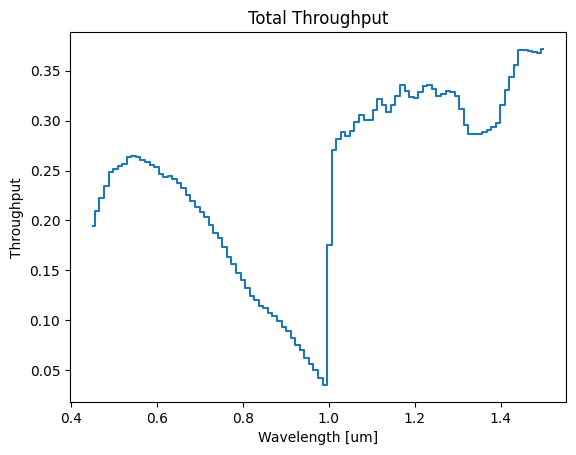

In [7]:
plt.figure()
plt.step(observation.wavelength, observatory.total_throughput, where="mid")
plt.xlabel("Wavelength [um]")
plt.ylabel("Throughput")
plt.title("Total Throughput")

### Why does throughput nosedive to 1. um?
This has to do with the assumed visible QE (see below)

Initializing Coronagraph Instrument
Loading file: /obs_config/CI/CI.yaml

Optical path:
['PM', 'SM', 'TCA', 'TCA', 'TCA', 'TCA', 'wave_beamsplitter', 'pol_beamsplitter', 'FSM', 'OAPs_forward', 'OAPs_forward', 'DM1', 'DM2', 'OAPs_forward', 'Fold', 'OAPs_back', 'Apodizer', 'OAPs_back', 'Focal_Plane_Mask', 'OAPs_back', 'Lyot_Stop', 'OAPs_back', 'Field_Stop', 'OAPs_back', 'filters', 'OAPs_back', 'Detector', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless']
Calculating throughput...
Calculating instrument throughput...
--including TCA
--including TCA
--including TCA
--including TCA
--including wave_beamsplitter
--including pol_beamsplitter
--including FSM
--including OAPs_forward
--including OAPs_forward
--including DM1
-

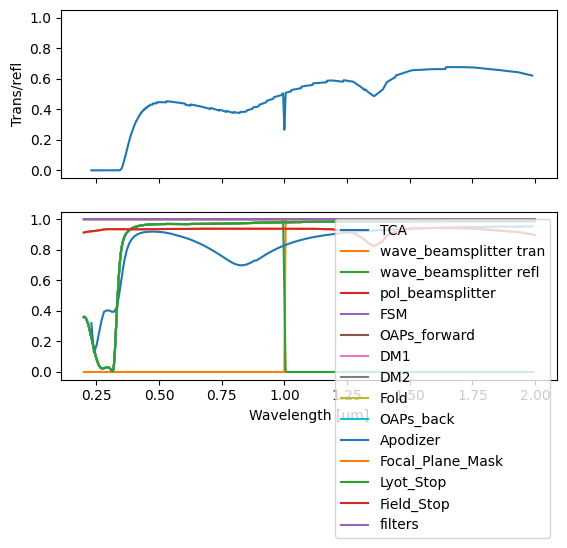

Loading IFS...


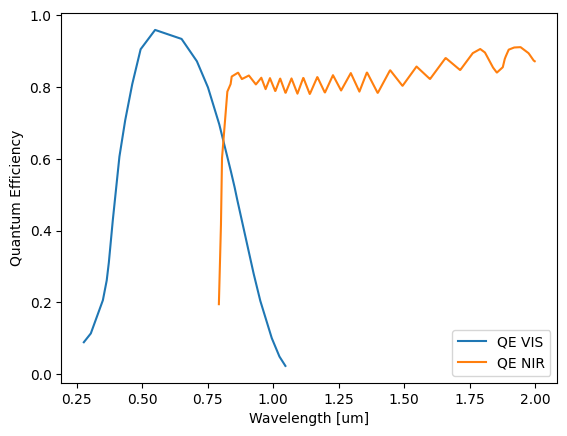

VISIBLE
-------
RN: 0.0
DC: 3e-05


NIR
---
RN: 0.4
DC: 0.0001


In [8]:
# to answer this, let's look in the YAML files for EAC1.
import eacy
eacy.load_instrument("CI", plotting=True, verbose=True) # load the coronagraph instrument given in the yaml files. This also calculates the throughput, and we can tell it to plot. 
eacy.load_detector("IFS", plotting=True, verbose=True) # load the detector instrument given in the yaml files. This also calculates the throughput, and we can tell it to plot.

### Coronagraph response maps

Text(0.5, 1.0, 'Coronagraph skytrans')

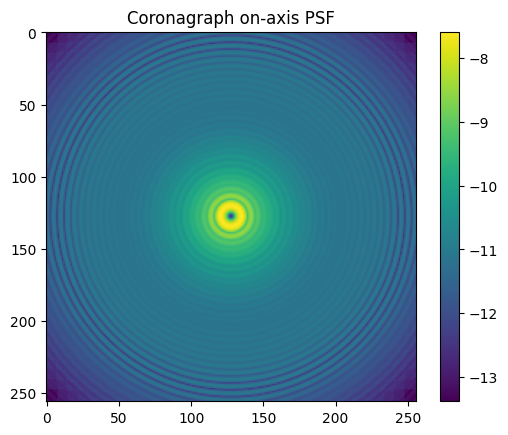

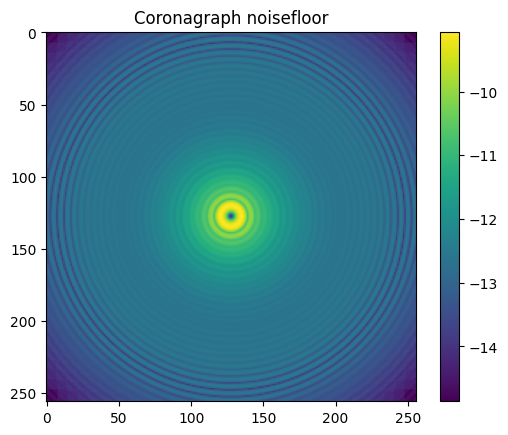

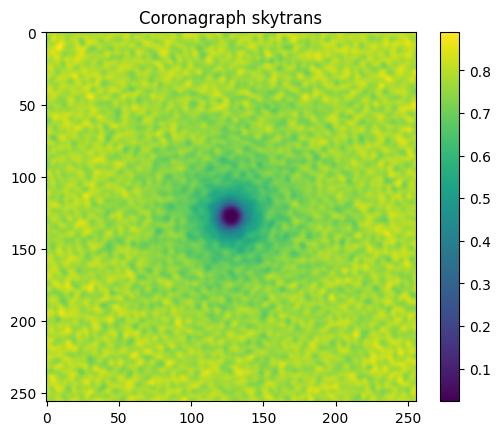

In [9]:
plt.figure()
plt.imshow(np.log10(observatory.coronagraph.Istar))
plt.colorbar()
plt.title("Coronagraph on-axis PSF")

plt.figure()
plt.imshow(np.log10(observatory.coronagraph.noisefloor))
plt.colorbar()
plt.title("Coronagraph noisefloor")

plt.figure()
plt.imshow(observatory.coronagraph.skytrans)
plt.colorbar()
plt.title("Coronagraph skytrans")



## Before running the ETC, let's take a look at some of the inputs:

Text(0.5, 1.0, 'Absolute Flux of the Star')

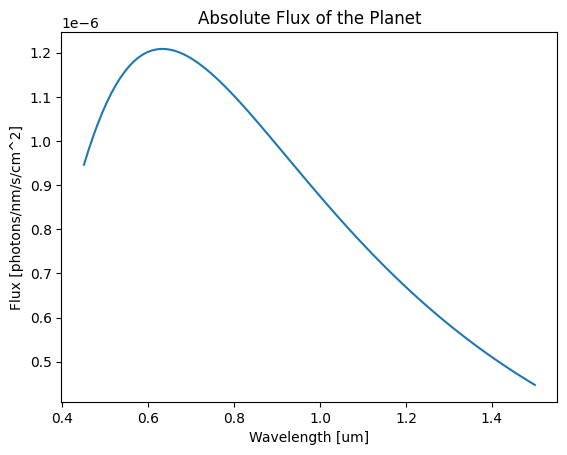

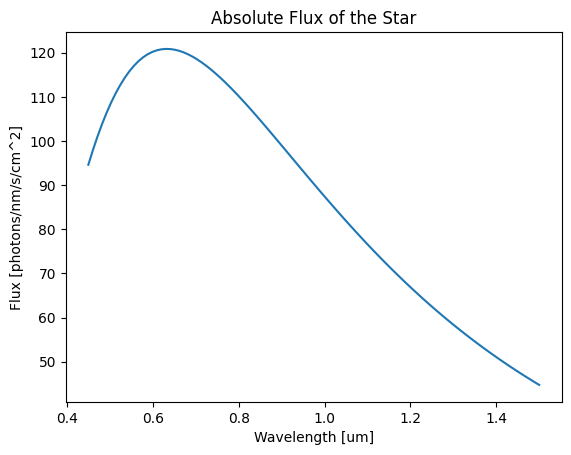

In [10]:
plt.figure()
plt.plot(observation.wavelength, (getattr(scene, "Fs_over_F0")*getattr(scene, "F0")*getattr(scene, "Fp_over_Fs")))
plt.xlabel("Wavelength [um]")
plt.ylabel("Flux [photons/nm/s/cm^2]")
plt.title("Absolute Flux of the Planet")

plt.figure()
plt.plot(observation.wavelength, (getattr(scene, "Fs_over_F0")*getattr(scene, "F0"))) # F0 is the zero-point and Fs_over_F0 is the ratio of the absolute flux to the zero point flux
plt.xlabel("Wavelength [um]")
plt.ylabel("Flux [photons/nm/s/cm^2]")
plt.title("Absolute Flux of the Star")


## Finally, let's run the exposure time calculation:
### After running, the calculated exposure times will be an attribute (exptime) of the pyEDITH object. 

In [11]:
pE.calculate_exposure_time_or_snr(observation, scene, observatory, verbose=False)

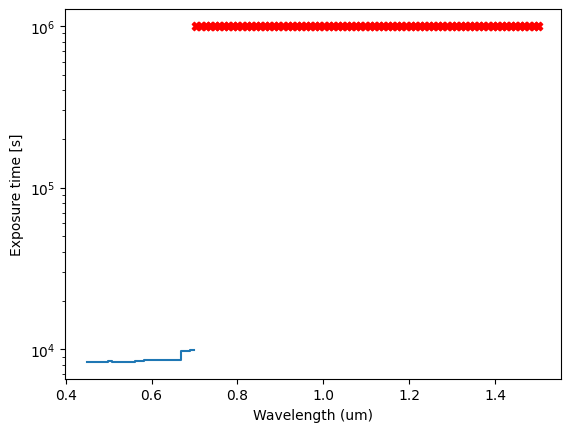

In [12]:
# Let's plot it:
plt.figure()
plt.step(observation.wavelength, observation.exptime, where="mid")
plt.scatter(observation.wavelength[np.isinf(observation.exptime)], 1e6*np.ones_like(observation.wavelength[np.isinf(observation.exptime)]), marker="X", color="red")


plt.ylabel("Exposure time [s]")
plt.xlabel("Wavelength (um)")

plt.yscale("log")

## We can also plot the individual photon counts to see if we're getting something reasonable.

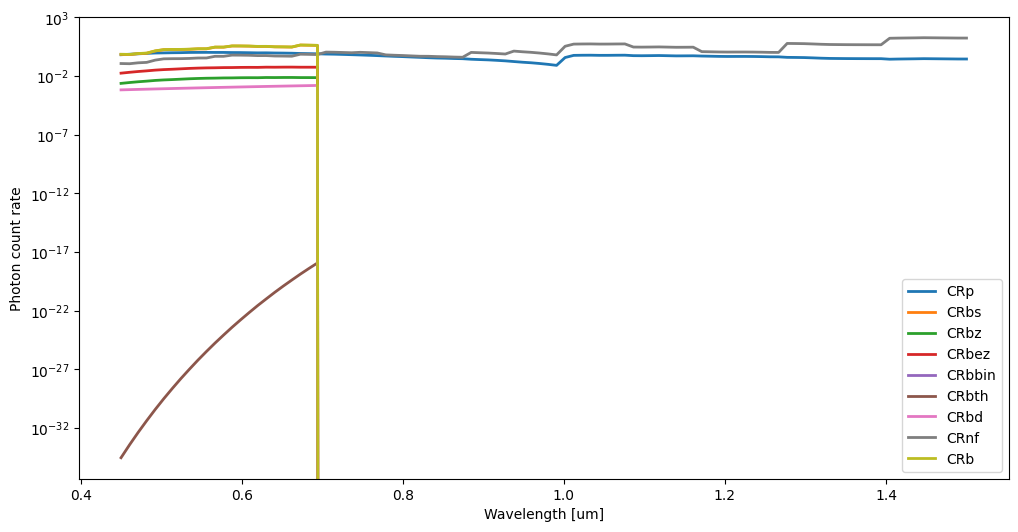

In [13]:
photon_counts = pickle.load(open("./photon_counts.pk", "rb"))
plt.figure(figsize=(12,6))
for key in photon_counts.keys():
    #print(key)
    #print(photon_counts[key])
    plt.plot(observation.wavelength, photon_counts[key], label=key, lw=2)
plt.yscale("log")
plt.ylabel("Photon count rate")
plt.xlabel("Wavelength [um]")
plt.legend()

## Why does the exposure time look blocky?
This has to do with the on-axis coronagraph response map (Istar). The planet is at a fixed separation in arcsec space, but the location is not fixed in lambda/D space. The planet appears to move closer to the star in lambd/D space with increasing wavelength, thus it experiences a different coronagraphic response. Since the on-axis PSF map is sampled at 0.25 lod, this limits our resolution for the contrast as a function of planet separation. 

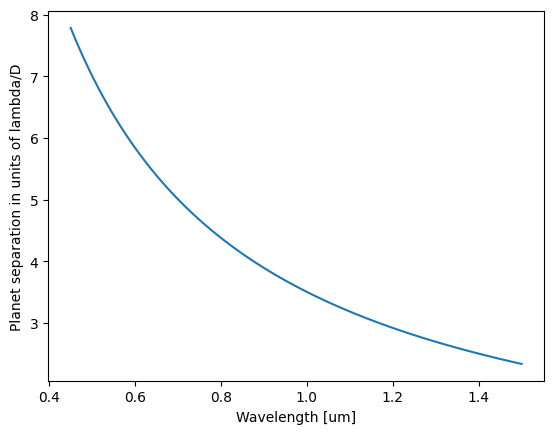

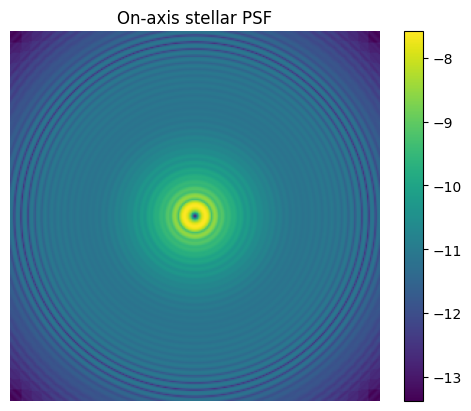

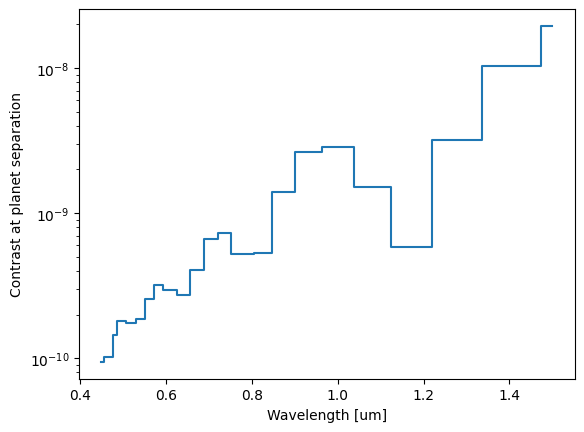

In [14]:
planet_separation_arcsec = scene.separation
planet_separation_rad = planet_separation_arcsec.to(u.rad)
tel_diam = observatory.telescope.diameter

wavelengths = observation.wavelength
planet_separation_lod = (planet_separation_rad.value * tel_diam) / wavelengths.to(u.m) 
plt.figure()
plt.plot(wavelengths, planet_separation_lod)
plt.xlabel("Wavelength [um]")
plt.ylabel("Planet separation in units of lambda/D")

# Let's revisit the on-axis stellar PSF map
plt.figure()
plt.imshow(np.log10(observatory.coronagraph.Istar))
plt.colorbar()
plt.title("On-axis stellar PSF")
plt.gca().axis("off")


# Now let's plot the coronagraphic response as a function of planetary separation
cgcenter = (observatory.coronagraph.npix - 1) / 2
cg_pixscale = 0.25 # lod units

planetary_separation_pix = planet_separation_lod/cg_pixscale + cgcenter

contrast_at_planet_sep = []
for sep in planetary_separation_pix:
    sepx = int(np.floor(sep))
    sepy = int(np.floor(cgcenter))
    contrast_at_planet_sep.append(observatory.coronagraph.Istar[sepy, sepx])

plt.figure()
plt.step(wavelengths, contrast_at_planet_sep, where="mid")
plt.xlabel("Wavelength [um]")
plt.ylabel("Contrast at planet separation")
plt.yscale("log")

